In [3]:
%matplotlib inline

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import sys
import numpy
import random

from utils import *
from models import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [5]:
# Hyper Parameters
max_sequence_length = 50
max_vocabulary_size = 25000
embedding_size = 300 
hidden_size = 256
num_layers = 1
batch_size = 150
num_epochs = 50
learning_rate = 0.001
dropout_rate = 0
teacher_forcing_ratio = 1

   
# train_data_path = 'train_Align_CNN_hid128_D0.50_Acc77.00_27449.txt'
# valid_data_path = 'valid_Align_CNN_hid128_D0.50_Acc77.00_27449.txt'
# test_data_path = 'test_align_twitter.txt'
# directory_name = 'classified_gen_Attn'

train_data_path = 'train_twit_only_align.txt'
valid_data_path = 'valid_twit_only_align.txt'
test_data_path = 'test_align_twitter.txt'
directory_name = 'labeled_gen_Attn'

encoder_name = 'AttENC'
decoder_name = 'AttDEC'

word_to_ix, ix_to_word, vocab_size = make_or_load_dict(train_data_path, character=False)
num_classes = vocab_size

4577


In [6]:
encoder = EncoderRNN(vocab_size, embedding_size, hidden_size, num_layers, 2, dropout_rate)
if decoder_name == 'AttDEC':
    decoder = AttnDecoderRNN(vocab_size, embedding_size, hidden_size, num_layers, num_classes, dropout_rate, max_sequence_length)
else:
    decoder = DecoderRNN(vocab_size, embedding_size, hidden_size, num_layers, num_classes, dropout_rate)

encoder = encoder.cuda()
decoder = decoder.cuda()
print(encoder)
print(decoder)

EncoderRNN(
  (dropout): Dropout(p=0)
  (word_embedding): Embedding(4577, 300)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2)
)
AttnDecoderRNN(
  (dropout): Dropout(p=0)
  (W_A): Linear(in_features=812, out_features=50)
  (word_embedding): Embedding(4577, 300)
  (W_C): Linear(in_features=812, out_features=512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=4577)
)


In [7]:
# # BiLSTM load 되는지 테스트
# model = BiLSTM(vocab_size, embedding_size, hidden_size, num_layers, 2, dropout_rate)
# model.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f_epoch_5_best_valid_loss.pkl' % (encoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))


In [8]:
# # load best_valid_loss model
# encoder.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f_epoch_5_best_valid_loss.pkl' % (encoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))
# decoder.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f_epoch_5_best_valid_loss.pkl' % (decoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))

In [9]:
# load last model.
encoder.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f_last_epoch.pkl' % (encoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))
decoder.load_state_dict(torch.load('./models/'+directory_name+'/%s_hid%d_D%0.2f_tfr%0.1f_last_epoch.pkl' % (decoder_name, hidden_size, dropout_rate, teacher_forcing_ratio)))

In [10]:
def evaluate(encoder, decoder, input_variable):
    encoder_outputs, encoder_hidden = encoder(input_variable, train=False)
    #max_sequence_length = encoder_outputs.size(1) # for simple dot product
    
    SOS_token = 0
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda()
    decoder_hidden = encoder_hidden
    decoder_hidden = decoder.initHidden(1, encoder_hidden)

    decoded_words = []
    decoder_attentions = torch.zeros(max_sequence_length, max_sequence_length)

    stop_at_next_endofsentence = 0
    if decoder_name == 'AttDEC':
        for di in range(max_sequence_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, train = False)
            decoder_attentions[di] = decoder_attention.view(-1, max_sequence_length).data

            # Choose top word from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoded_words.append(ni)
            if ni ==1: break

            # Next input is chosen word
            decoder_input = Variable(torch.LongTensor([[ni]])).cuda()
    else:
        for _ in range(max_sequence_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, train = False)

            # Choose top word from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoded_words.append(ni)
            if ni ==1: 
                if decoder_name == 'AE' and stop_at_next_endofsentence !=1:
                    stop_at_next_endofsentence = 1
                elif decoder_name == 'AE' and stop_at_next_endofsentence == 1:
                    break
                else:
                    break

            # Next input is chosen word
            decoder_input = Variable(torch.LongTensor([[ni]])).cuda()
        
    if decoder_name == 'AttDEC':
        return decoded_words, decoder_attentions[:di + 1]
    else:
        return decoded_words

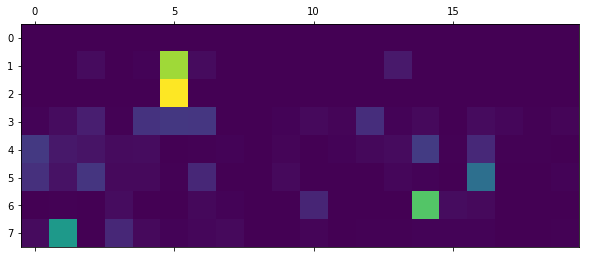

In [11]:
sentence = '¡ quítate de la puerta ! endofsentence'
sentence = sentence.split()
sentence_tensor = prepare_sequence(sentence, word_to_ix)
sentence = Variable(sentence_tensor.view(1, -1)).cuda()

output_words, attentions = evaluate(
    encoder, decoder, sentence)
#plt.matshow(attentions.numpy())
plt.matshow(attentions.numpy()[:, :20])

input = De ustedes depende para qué utilizar sus manos ... acariciar , abrazar o dar palmas endofsentence
output = yo quisiera tocar las tuyas .. endofsentence


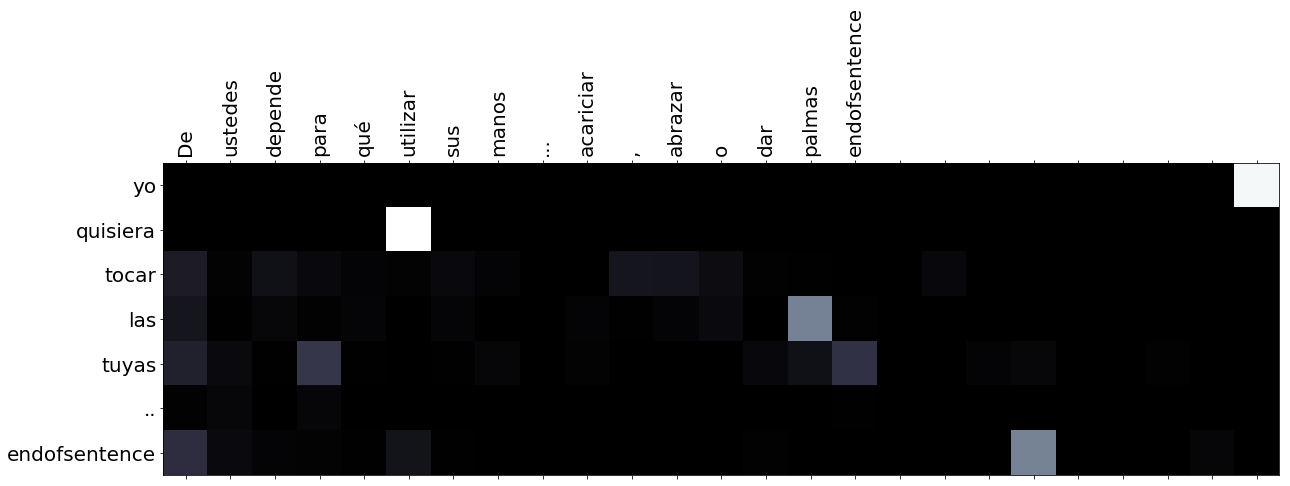

input = Siempre se hacen bromas de la mala memoria del venezolano , pero jamás pensé que muchos se olvidarían de la lucha de ello … endofsentence
output = que gran equipo ! endofsentence


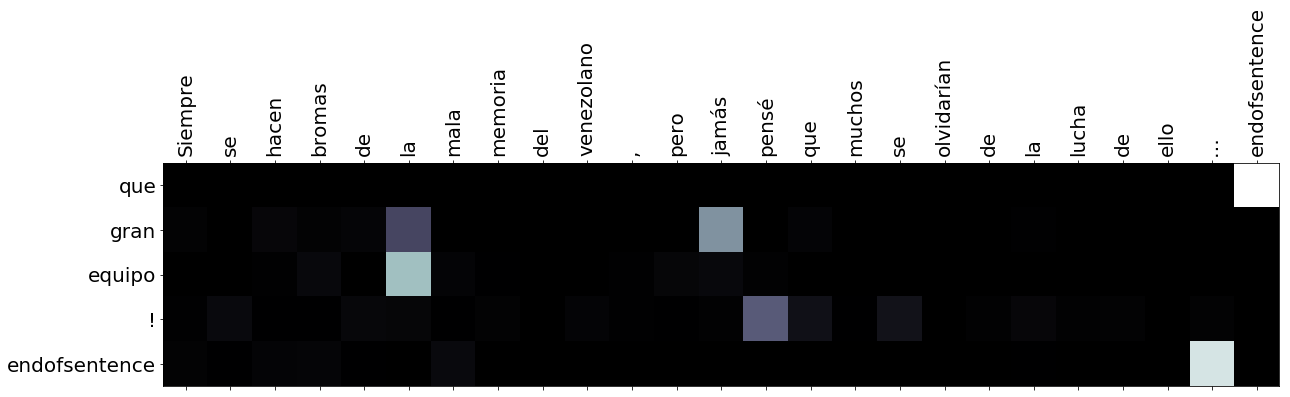

In [44]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    matplotlib.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions.numpy()[:, :25], cmap='bone')
    #fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder, decoder, sentence_to_input(input_sentence))
    print('input =', input_sentence)
    output_words = [ix_to_word[word_idx] for word_idx in output_words]
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


def sentence_to_input(sentence):
    sentence = sentence.split()
    sentence_tensor = prepare_sequence(sentence, word_to_ix)
    sentence = Variable(sentence_tensor.view(1, -1)).cuda()
    return sentence


# classified
#evaluateAndShowAttention("felicidades por alcanzar la meta en teletón para ayudar a compatriotas con capacidades especiales . exc … endofsentence")

#evaluateAndShowAttention("os tatuáis la fecha de nacimiento en números romanos , el nombre del perro en cirílico , el del hijo en japonés , “ te quiero … endofsentence")

# labled
evaluateAndShowAttention("De ustedes depende para qué utilizar sus manos ... acariciar , abrazar o dar palmas endofsentence")

evaluateAndShowAttention("Siempre se hacen bromas de la mala memoria del venezolano , pero jamás pensé que muchos se olvidarían de la lucha de ello … endofsentence")

#evaluateAndShowAttention("es que no puedo parar de ver stranger things . estamos todos igual no ? endofsentence")

